In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import clear_output

# ライブラリのimportを行います
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import json

import re
import unicodedata
from kanjize import kanji2number
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import lightgbm as lgb
import logging
logging.getLogger("lightgbm").setLevel(logging.WARNING)
from sklearn.metrics import accuracy_score

from imblearn.under_sampling import RandomUnderSampler
from tqdm.auto import tqdm

from sklearn.metrics import log_loss
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

# LightAutoMLのライブラリ
# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco
from lightautoml.ml_algo.torch_based.nn_models import MLP, DenseLightModel

C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:42: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\text\embed.py:22: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\text\dl_transformers.py:25: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")


In [3]:
import random
import string
from datetime import datetime

def generate_custom_id(prefix="USER", length=6):
    # 日付を取得
    date_str = datetime.now().strftime("%Y%m%d")
    
    # ランダムな数字や文字を生成
    random_part = ''.join(random.choices(string.ascii_uppercase + string.digits, k=length))
    
    # IDを結合
    custom_id = f"{prefix}-{date_str}-{random_part}"
    
    return custom_id

# IDを発行
generated_id = generate_custom_id()
print("Generated ID:", generated_id)


Generated ID: USER-20240823-3POP9L


# Config

# 提出ファイル作成用

In [4]:
def make_submitfile(submit_date = "0815",filename = "submission", version = "00", data = []):
    submit = pd.read_csv("data/sample_submit.csv", header=None)
    # 提出ファイルの2列目を予測値で置き換えます。
    submit[1] = data
    submit.to_csv(f"output/{submit_date}{filename}_{version}.csv", index=False, header=None)

In [5]:
class RESULT_class:
    def __init__(self):
        self.RESULT_CONFIG = pd.DataFrame()
        self.oof_valid_df = pd.DataFrame()
        self.oof_test_df = pd.DataFrame()

    def addResult(self, model_name,
                  layer1,
                  layer2,
                  feature_selection,
                  under_sampling,
                  PCAd,
                  columns,
                  skf_num,
                  skf_rand,
                  score,
                  oof_valid,
                  oof_test,
                  date = "0821"):

        ID = len(self.RESULT_CONFIG)+1
        tmp = pd.DataFrame([[ID, model_name, layer1, layer2, feature_selection,under_sampling,PCAd,columns,skf_num,skf_rand,score,date]])
        tmp.columns = ["ID","model_name","layer1","layer2","feature_selection","under_sampling","PCA(d)","columns","skf_num","skf_rand","score","date"]
        
        if len(self.RESULT_CONFIG)>0:
            self.RESULT_CONFIG = pd.concat([self.RESULT_CONFIG, tmp])
        else:
            self.RESULT_CONFIG = tmp

        self.oof_valid_df[ID] = pd.DataFrame(oof_valid)
        self.oof_test_df[ID] = pd.DataFrame(oof_test)

Rc = RESULT_class()

In [6]:
def addResult(automl, df_dict, y, Rc):
    oof_valid = automl.predict(df_dict["train"])
    oof_test = automl.predict(df_dict["test"])
    score = roc_auc_score(y, oof_valid.data)
    
    if len(automl.general_params["use_algos"]) > 1:
        layer1 = automl.general_params["use_algos"][0]
        layer2 = automl.general_params["use_algos"][1]
    else:
        layer1 = automl.general_params["use_algos"]
        layer2 = []
    
    features = automl.collect_used_feats()
    n_folds = automl.reader_params["cv"]
    random_state = automl.reader_params["random_state"]
    
    Rc.addResult("LAMA", layer1, layer2, True, False, False, features, n_folds, random_state, score, oof_valid.data, oof_test.data)

# Dataload

In [7]:
train = pd.read_csv("data/input_train.csv")
test = pd.read_csv("data/input_test.csv")

In [8]:
df_dict = {"train":train,
          "test":test}
y = df_dict["train"]["ProdTaken"]
X = df_dict["train"].drop(columns=['id', 'customer_info', "ProdTaken"], axis=1)
test = df_dict["test"].drop(columns=['id', 'customer_info'], axis=1)

In [9]:
scaler = StandardScaler()
train_scalar = scaler.fit_transform(X)
test_scalar = scaler.transform(test)

In [10]:
columns = X.columns.tolist()
X = pd.DataFrame(train_scalar,columns = columns)
test = pd.DataFrame(test_scalar,columns = columns)

In [11]:
df_dict["train"] = pd.concat([X,y],axis=1)
df_dict["test"] =test

# Training Phase

## LightAutoMLの設定

In [12]:
N_THREADS = 4
N_FOLDS = [5, 3]
RANDOM_STATE = 42
TIMEOUT = 21600

## params

In [13]:
task = Task('binary', metric = 'auc')
roles = {
    'target': "ProdTaken",
    'drop': ['id',"customer_info"]
    }

In [14]:
default_lama_params = {
    "task": task,
    "timeout": TIMEOUT,
    "cpu_limit": N_THREADS,
    "reader_params": {'n_jobs': N_THREADS, 'cv': N_FOLDS[0], 'random_state': RANDOM_STATE}
}

default_nn_params = {
    "bs": 512, "num_workers": 0, "path_to_save": None, "n_epochs": 1000, "freeze_defaults": True
}

In [15]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

# base

In [16]:
for i in range(2):
    automl = TabularAutoML(
        memory_limit = 64,
        task = task,
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS[i], 'random_state': RANDOM_STATE},
    )
    automl.fit_predict(df_dict["train"], roles = roles, verbose = 1)
    addResult(automl, df_dict, y, Rc)

[14:03:10] Stdout logging level is INFO.
[14:03:10] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[14:03:10] Task: binary

[14:03:10] Start automl preset with listed constraints:
[14:03:10] - time: 21600.00 seconds
[14:03:10] - CPU: 4 cores
[14:03:10] - memory: 64 GB

[14:03:10] Train data shape: (3489, 104)

[14:03:13] Layer 1 train process start. Time left 21597.10 secs
[14:03:14] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[14:03:17] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8297882213064482
[14:03:17] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[14:03:17] Time left 21593.27 secs

[14:03:18] Selector_LightGBM fitting and predicting completed
[14:03:18] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[14:03:19] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8262428851181958
[14:03:19] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[14:03:19] Start hyperparameters optimization fo

### 複数レイヤー

In [17]:
for i in range(2):
    automl = TabularAutoML(
        task = task,
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS[i], 'random_state': RANDOM_STATE},
        general_params={
            'use_algos': [
                ['lgb', 'lgb_tuned', 'linear_l2', 'cb', 'cb_tuned'],  # 最初のレベル（レイヤー1）で使用するアルゴリズム
                ['linear_l2', 'rf']  # 次のレベル（レイヤー2）で使用するアルゴリズム
            ]
        },
        nn_params={
            **default_nn_params,
            "n_epochs": 1000,
            "tuning_params": {
                "max_tuning_iter": 5,
                "max_tuning_time": 3600,
                "fit_on_holdout": True
            }
        },
        
    )
    automl.fit_predict(df_dict["train"], roles = roles, verbose = 1)
    addResult(automl, df_dict, y, Rc)

[14:09:47] Stdout logging level is INFO.
[14:09:47] Task: binary

[14:09:47] Start automl preset with listed constraints:
[14:09:47] - time: 21600.00 seconds
[14:09:47] - CPU: 4 cores
[14:09:47] - memory: 16 GB

[14:09:47] Train data shape: (3489, 104)

[14:09:47] Layer 1 train process start. Time left 21599.74 secs
[14:09:47] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[14:09:49] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8297882213064482
[14:09:49] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[14:09:49] Time left 21597.80 secs

[14:09:49] Selector_LightGBM fitting and predicting completed
[14:09:50] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[14:09:51] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8262428851181958
[14:09:51] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[14:09:51] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
[14:10:48] Hyperparameters optimization for

# TablerNN

In [18]:
for i in range(2):
    automl = TabularAutoML(
                task = task,
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS[i], 'random_state': RANDOM_STATE},
        gpu_ids='0',
        general_params = {"use_algos": [['nn', 'mlp', 'dense', 'denselight', 'resnet', 'snn', 'node', 'autoint', 'fttransformer']]}, # ['nn', 'mlp', 'dense', 'denselight', 'resnet', 'snn', 'node', 'autoint', 'fttransformer'] or custom torch model
        nn_params = {"n_epochs": 1000, "bs": 512, "num_workers": 0, "path_to_save": None, "freeze_defaults": True},
        nn_pipeline_params = {"use_qnt": True, "use_te": False},
    )
    
    automl.fit_predict(df_dict["train"], roles = roles, verbose = 1)
    addResult(automl, df_dict, y, Rc)

[14:16:28] Stdout logging level is INFO.
[14:16:28] Task: binary

[14:16:28] Start automl preset with listed constraints:
[14:16:28] - time: 21600.00 seconds
[14:16:28] - CPU: 4 cores
[14:16:28] - memory: 16 GB

[14:16:28] Train data shape: (3489, 104)

[14:16:29] Layer 1 train process start. Time left 21599.79 secs
[14:16:29] Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN_mlp_0 ...
[14:16:49] Fitting Lvl_0_Pipe_0_Mod_0_TorchNN_mlp_0 finished. score = 0.8150655268509454
[14:16:49] Lvl_0_Pipe_0_Mod_0_TorchNN_mlp_0 fitting and predicting completed
[14:16:49] Start fitting Lvl_0_Pipe_0_Mod_1_TorchNN_mlp_1 ...
[14:17:08] Fitting Lvl_0_Pipe_0_Mod_1_TorchNN_mlp_1 finished. score = 0.8163529976651352
[14:17:08] Lvl_0_Pipe_0_Mod_1_TorchNN_mlp_1 fitting and predicting completed
[14:17:08] Start fitting Lvl_0_Pipe_0_Mod_2_TorchNN_dense_2 ...
[14:17:20] Fitting Lvl_0_Pipe_0_Mod_2_TorchNN_dense_2 finished. score = 0.5291303301089962
[14:17:20] Lvl_0_Pipe_0_Mod_2_TorchNN_dense_2 fitting and predicting co

## Turned

In [19]:
for i in range(2):
    automl = TabularAutoML(
        task = task,
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS[i], 'random_state': RANDOM_STATE},
        general_params={"use_algos": [['nn_tuned', 'mlp_tuned', 'dense_tuned',"denselight_tuned", 'resnet_tuned', 'snn_tuned', 'node_tuned', 'autoint_tuned', 'fttransformer_tuned']]},
        nn_params={
            **default_nn_params,
            "n_epochs": 1000,
            "tuning_params": {
                "max_tuning_iter": 5,
                "max_tuning_time": 3600,
                "fit_on_holdout": True
            }
        },
    )
    automl.fit_predict(df_dict["train"], roles = roles, verbose = 1)
    addResult(automl, df_dict, y, Rc)

[14:30:53] Stdout logging level is INFO.
[14:30:53] Task: binary

[14:30:53] Start automl preset with listed constraints:
[14:30:53] - time: 21600.00 seconds
[14:30:53] - CPU: 4 cores
[14:30:53] - memory: 16 GB

[14:30:53] Train data shape: (3489, 104)

[14:30:56] Layer 1 train process start. Time left 21597.03 secs
[14:30:56] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_0_Tuned_TorchNN_mlp_0 ... Time budget is 1478.90 secs


C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:640: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

[14:32:02] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_0_Tuned_TorchNN_mlp_0 completed
[14:32:02] Start fitting Lvl_0_Pipe_0_Mod_0_Tuned_TorchNN_mlp_0 ...
[14:33:47] Fitting Lvl_0_Pipe_0_Mod_0_Tuned_TorchNN_mlp_0 finished. score = 0.8244470163225341
[14:33:47] Lvl_0_Pipe_0_Mod_0_Tuned_TorchNN_mlp_0 fitting and predicting completed
[14:33:47] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_1_Tuned_TorchNN_mlp_tuned_1 ... Time budget is 2194.21 secs


C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:640: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

[14:34:52] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_1_Tuned_TorchNN_mlp_tuned_1 completed
[14:34:52] Start fitting Lvl_0_Pipe_0_Mod_1_Tuned_TorchNN_mlp_tuned_1 ...
[14:36:37] Fitting Lvl_0_Pipe_0_Mod_1_Tuned_TorchNN_mlp_tuned_1 finished. score = 0.8252449187101216
[14:36:37] Lvl_0_Pipe_0_Mod_1_Tuned_TorchNN_mlp_tuned_1 fitting and predicting completed
[14:36:37] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_2_Tuned_TorchNN_dense_tuned_2 ... Time budget is 2496.94 secs


C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:640: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

[14:37:04] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_2_Tuned_TorchNN_dense_tuned_2 completed
[14:37:04] Start fitting Lvl_0_Pipe_0_Mod_2_Tuned_TorchNN_dense_tuned_2 ...
[14:38:04] Fitting Lvl_0_Pipe_0_Mod_2_Tuned_TorchNN_dense_tuned_2 finished. score = 0.6969332707474796
[14:38:04] Lvl_0_Pipe_0_Mod_2_Tuned_TorchNN_dense_tuned_2 fitting and predicting completed
[14:38:04] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_3_Tuned_TorchNN_denselight_tuned_3 ... Time budget is 2910.62 secs


C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:640: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

[14:39:21] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_3_Tuned_TorchNN_denselight_tuned_3 completed
[14:39:21] Start fitting Lvl_0_Pipe_0_Mod_3_Tuned_TorchNN_denselight_tuned_3 ...
[14:40:25] Fitting Lvl_0_Pipe_0_Mod_3_Tuned_TorchNN_denselight_tuned_3 finished. score = 0.8174024091070489
[14:40:25] Lvl_0_Pipe_0_Mod_3_Tuned_TorchNN_denselight_tuned_3 fitting and predicting completed
[14:40:25] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_4_Tuned_TorchNN_resnet_tuned_4 ... Time budget is 3473.15 secs


C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:640: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

[14:41:19] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_4_Tuned_TorchNN_resnet_tuned_4 completed
[14:41:19] Start fitting Lvl_0_Pipe_0_Mod_4_Tuned_TorchNN_resnet_tuned_4 ...
[14:41:37] Fitting Lvl_0_Pipe_0_Mod_4_Tuned_TorchNN_resnet_tuned_4 finished. score = 0.8275024478421329
[14:41:37] Lvl_0_Pipe_0_Mod_4_Tuned_TorchNN_resnet_tuned_4 fitting and predicting completed
[14:41:37] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_5_Tuned_TorchNN_snn_tuned_5 ... Time budget is 3600.00 secs


C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:640: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

[14:42:12] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_5_Tuned_TorchNN_snn_tuned_5 completed
[14:42:12] Start fitting Lvl_0_Pipe_0_Mod_5_Tuned_TorchNN_snn_tuned_5 ...
[14:42:18] Fitting Lvl_0_Pipe_0_Mod_5_Tuned_TorchNN_snn_tuned_5 finished. score = 0.8362131344215021
[14:42:18] Lvl_0_Pipe_0_Mod_5_Tuned_TorchNN_snn_tuned_5 fitting and predicting completed
[14:42:18] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_6_Tuned_TorchNN_node_tuned_6 ... Time budget is 3600.00 secs


C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:640: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

[14:47:52] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_6_Tuned_TorchNN_node_tuned_6 completed
[14:47:52] Start fitting Lvl_0_Pipe_0_Mod_6_Tuned_TorchNN_node_tuned_6 ...
[14:51:32] Fitting Lvl_0_Pipe_0_Mod_6_Tuned_TorchNN_node_tuned_6 finished. score = 0.8234877177503523
[14:51:32] Lvl_0_Pipe_0_Mod_6_Tuned_TorchNN_node_tuned_6 fitting and predicting completed
[14:51:32] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_7_Tuned_TorchNN_autoint_tuned_7 ... Time budget is 3600.00 secs


C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:640: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

[14:57:14] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_7_Tuned_TorchNN_autoint_tuned_7 completed
[14:57:14] Start fitting Lvl_0_Pipe_0_Mod_7_Tuned_TorchNN_autoint_tuned_7 ...
[14:58:51] Fitting Lvl_0_Pipe_0_Mod_7_Tuned_TorchNN_autoint_tuned_7 finished. score = 0.7999568265206211
[14:58:51] Lvl_0_Pipe_0_Mod_7_Tuned_TorchNN_autoint_tuned_7 fitting and predicting completed
[14:58:51] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_8_Tuned_TorchNN_fttransformer_tuned_8 ... Time budget is 3600.00 secs


C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:640: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

[15:13:04] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_8_Tuned_TorchNN_fttransformer_tuned_8 completed
[15:13:04] Start fitting Lvl_0_Pipe_0_Mod_8_Tuned_TorchNN_fttransformer_tuned_8 ...
[15:15:32] Fitting Lvl_0_Pipe_0_Mod_8_Tuned_TorchNN_fttransformer_tuned_8 finished. score = 0.8247785509850547
[15:15:32] Lvl_0_Pipe_0_Mod_8_Tuned_TorchNN_fttransformer_tuned_8 fitting and predicting completed
[15:15:32] Time left 18920.68 secs

[15:15:32] Layer 1 training completed.

[15:15:32] Blending: optimization starts with equal weights and score 0.8312710487524074
[15:15:32] Blending: iteration 0: score = 0.8376105563864471, weights = [0.         0.         0.         0.         0.         0.8211404
 0.         0.05133308 0.12752648]
[15:15:32] Blending: iteration 1: score = 0.8377235337156628, weights = [0.         0.         0.         0.         0.16655181 0.56457114
 0.0703744  0.         0.19850266]
[15:15:32] Blending: iteration 2: score = 0.837788764673603, weights = [0.         0.

C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:640: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

[15:17:45] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_0_Tuned_TorchNN_mlp_0 completed
[15:17:45] Start fitting Lvl_0_Pipe_0_Mod_0_Tuned_TorchNN_mlp_0 ...
[15:18:34] Fitting Lvl_0_Pipe_0_Mod_0_Tuned_TorchNN_mlp_0 finished. score = 0.8245135922486794
[15:18:34] Lvl_0_Pipe_0_Mod_0_Tuned_TorchNN_mlp_0 fitting and predicting completed
[15:18:34] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_1_Tuned_TorchNN_mlp_tuned_1 ... Time budget is 2297.40 secs


C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:640: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

[15:20:33] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_1_Tuned_TorchNN_mlp_tuned_1 completed
[15:20:33] Start fitting Lvl_0_Pipe_0_Mod_1_Tuned_TorchNN_mlp_tuned_1 ...
[15:21:23] Fitting Lvl_0_Pipe_0_Mod_1_Tuned_TorchNN_mlp_tuned_1 finished. score = 0.8244668546035571
[15:21:23] Lvl_0_Pipe_0_Mod_1_Tuned_TorchNN_mlp_tuned_1 fitting and predicting completed
[15:21:23] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_2_Tuned_TorchNN_dense_tuned_2 ... Time budget is 2599.35 secs


C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:640: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

[15:21:52] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_2_Tuned_TorchNN_dense_tuned_2 completed
[15:21:52] Start fitting Lvl_0_Pipe_0_Mod_2_Tuned_TorchNN_dense_tuned_2 ...
[15:22:09] Fitting Lvl_0_Pipe_0_Mod_2_Tuned_TorchNN_dense_tuned_2 finished. score = 0.5022965332099549
[15:22:09] Lvl_0_Pipe_0_Mod_2_Tuned_TorchNN_dense_tuned_2 fitting and predicting completed
[15:22:09] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_3_Tuned_TorchNN_denselight_tuned_3 ... Time budget is 3019.78 secs


C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:640: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

[15:24:32] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_3_Tuned_TorchNN_denselight_tuned_3 completed
[15:24:32] Start fitting Lvl_0_Pipe_0_Mod_3_Tuned_TorchNN_denselight_tuned_3 ...
[15:25:27] Fitting Lvl_0_Pipe_0_Mod_3_Tuned_TorchNN_denselight_tuned_3 finished. score = 0.8238525403759455
[15:25:27] Lvl_0_Pipe_0_Mod_3_Tuned_TorchNN_denselight_tuned_3 fitting and predicting completed
[15:25:27] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_4_Tuned_TorchNN_resnet_tuned_4 ... Time budget is 3530.85 secs


C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:640: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

[15:26:51] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_4_Tuned_TorchNN_resnet_tuned_4 completed
[15:26:51] Start fitting Lvl_0_Pipe_0_Mod_4_Tuned_TorchNN_resnet_tuned_4 ...
[15:27:03] Fitting Lvl_0_Pipe_0_Mod_4_Tuned_TorchNN_resnet_tuned_4 finished. score = 0.8262919764576765
[15:27:03] Lvl_0_Pipe_0_Mod_4_Tuned_TorchNN_resnet_tuned_4 fitting and predicting completed
[15:27:03] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_5_Tuned_TorchNN_snn_tuned_5 ... Time budget is 3600.00 secs


C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:640: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

[15:28:28] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_5_Tuned_TorchNN_snn_tuned_5 completed
[15:28:28] Start fitting Lvl_0_Pipe_0_Mod_5_Tuned_TorchNN_snn_tuned_5 ...
[15:29:15] Fitting Lvl_0_Pipe_0_Mod_5_Tuned_TorchNN_snn_tuned_5 finished. score = 0.8342380486125307
[15:29:15] Lvl_0_Pipe_0_Mod_5_Tuned_TorchNN_snn_tuned_5 fitting and predicting completed
[15:29:15] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_6_Tuned_TorchNN_node_tuned_6 ... Time budget is 3600.00 secs


C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:640: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

[15:36:15] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_6_Tuned_TorchNN_node_tuned_6 completed
[15:36:15] Start fitting Lvl_0_Pipe_0_Mod_6_Tuned_TorchNN_node_tuned_6 ...
[15:38:40] Fitting Lvl_0_Pipe_0_Mod_6_Tuned_TorchNN_node_tuned_6 finished. score = 0.8193707700749955
[15:38:40] Lvl_0_Pipe_0_Mod_6_Tuned_TorchNN_node_tuned_6 fitting and predicting completed
[15:38:40] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_7_Tuned_TorchNN_autoint_tuned_7 ... Time budget is 3600.00 secs


C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:640: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

[15:44:43] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_7_Tuned_TorchNN_autoint_tuned_7 completed
[15:44:43] Start fitting Lvl_0_Pipe_0_Mod_7_Tuned_TorchNN_autoint_tuned_7 ...
[15:45:43] Fitting Lvl_0_Pipe_0_Mod_7_Tuned_TorchNN_autoint_tuned_7 finished. score = 0.8087690581994641
[15:45:43] Lvl_0_Pipe_0_Mod_7_Tuned_TorchNN_autoint_tuned_7 fitting and predicting completed
[15:45:43] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_8_Tuned_TorchNN_fttransformer_tuned_8 ... Time budget is 3600.00 secs


C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:640: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

[15:59:18] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_8_Tuned_TorchNN_fttransformer_tuned_8 completed
[15:59:18] Start fitting Lvl_0_Pipe_0_Mod_8_Tuned_TorchNN_fttransformer_tuned_8 ...
[16:01:33] Fitting Lvl_0_Pipe_0_Mod_8_Tuned_TorchNN_fttransformer_tuned_8 finished. score = 0.8305958747135218
[16:01:33] Lvl_0_Pipe_0_Mod_8_Tuned_TorchNN_fttransformer_tuned_8 fitting and predicting completed
[16:01:33] Time left 18850.26 secs

[16:01:33] Layer 1 training completed.

[16:01:33] Blending: optimization starts with equal weights and score 0.8183990305469178
[16:01:33] Blending: iteration 0: score = 0.8358432681651404, weights = [0.         0.         0.         0.         0.05457416 0.6454283
 0.         0.0817111  0.21828645]
[16:01:33] Blending: iteration 1: score = 0.8358654601405222, weights = [0.         0.         0.         0.         0.05545682 0.6558672
 0.         0.06643218 0.22224382]
[16:01:33] Blending: iteration 2: score = 0.8358688225610347, weights = [0.         0.

### 複数レイヤー

In [20]:
automl = TabularAutoML(
    **default_lama_params,
    general_params={
        'use_algos': [
            ['nn', 'mlp', 'dense', 'denselight', 'resnet', 'snn', 'node', 'autoint', 'fttransformer_tuned'],  # 最初のレベル（レイヤー1）で使用するアルゴリズム
            ['linear_l2', 'rf']  # 次のレベル（レイヤー2）で使用するアルゴリズム
        ]
    },
    nn_params={
        **default_nn_params,
        "n_epochs": 1000,
        "tuning_params": {
            "max_tuning_iter": 5,
            "max_tuning_time": 3600,
            "fit_on_holdout": True
        }
    }
)
automl.fit_predict(df_dict["train"], roles = roles, verbose = 1)
addResult(automl, df_dict, y, Rc)

[16:01:41] Stdout logging level is INFO.
[16:01:41] Task: binary

[16:01:41] Start automl preset with listed constraints:
[16:01:41] - time: 21600.00 seconds
[16:01:41] - CPU: 4 cores
[16:01:41] - memory: 16 GB

[16:01:41] Train data shape: (3489, 104)

[16:01:45] Layer 1 train process start. Time left 21596.76 secs
[16:01:45] Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN_mlp_0 ...
[16:02:06] Fitting Lvl_0_Pipe_0_Mod_0_TorchNN_mlp_0 finished. score = 0.8215529809875295
[16:02:06] Lvl_0_Pipe_0_Mod_0_TorchNN_mlp_0 fitting and predicting completed
[16:02:06] Start fitting Lvl_0_Pipe_0_Mod_1_TorchNN_mlp_1 ...
[16:02:27] Fitting Lvl_0_Pipe_0_Mod_1_TorchNN_mlp_1 finished. score = 0.8221477931761694
[16:02:27] Lvl_0_Pipe_0_Mod_1_TorchNN_mlp_1 fitting and predicting completed
[16:02:27] Start fitting Lvl_0_Pipe_0_Mod_2_TorchNN_dense_2 ...
[16:02:38] Fitting Lvl_0_Pipe_0_Mod_2_TorchNN_dense_2 finished. score = 0.5959446518684299
[16:02:38] Lvl_0_Pipe_0_Mod_2_TorchNN_dense_2 fitting and predicting co

C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:640: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

[16:20:47] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_8_Tuned_TorchNN_fttransformer_tuned_8 completed
[16:20:47] Start fitting Lvl_0_Pipe_0_Mod_8_Tuned_TorchNN_fttransformer_tuned_8 ...
[16:23:13] Fitting Lvl_0_Pipe_0_Mod_8_Tuned_TorchNN_fttransformer_tuned_8 finished. score = 0.8247785509850547
[16:23:13] Lvl_0_Pipe_0_Mod_8_Tuned_TorchNN_fttransformer_tuned_8 fitting and predicting completed
[16:23:13] Time left 20308.09 secs

[16:23:13] Layer 1 training completed.

[16:23:13] Layer 2 train process start. Time left 20308.08 secs
[16:23:13] Start fitting Lvl_1_Pipe_0_Mod_0_RFSklearn ...
[16:23:16] Fitting Lvl_1_Pipe_0_Mod_0_RFSklearn finished. score = 0.8290041048429615
[16:23:16] Lvl_1_Pipe_0_Mod_0_RFSklearn fitting and predicting completed
[16:23:16] Time left 20305.20 secs

[16:23:16] Start fitting Lvl_1_Pipe_1_Mod_0_LinearL2 ...
[16:23:19] Fitting Lvl_1_Pipe_1_Mod_0_LinearL2 finished. score = 0.8161300691851644
[16:23:19] Lvl_1_Pipe_1_Mod_0_LinearL2 fitting and predicting co

# Layer 2

In [21]:
automl = TabularAutoML(
    **default_lama_params,
    general_params={
        'use_algos': [
            ['lgb_tuned', 'cb_tuned', 'et_tuned', 'resnet_tuned', 'fttransformer_tuned'],  # 最初のレベル（レイヤー1）で使用するアルゴリズム
            ['linear_l2', 'mlp']  # 次のレベル（レイヤー2）で使用するアルゴリズム
        ]
    },
    nn_params={
        **default_nn_params,
        "n_epochs": 1000,
        "tuning_params": {
            "max_tuning_iter": 5,
            "max_tuning_time": 3600,
            "fit_on_holdout": True
        }
    }
    #reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS[0], 'random_state': RANDOM_STATE}
)
automl.fit_predict(df_dict["train"], roles = roles, verbose = 1)
addResult(automl, df_dict, y, Rc)

[16:23:41] Stdout logging level is INFO.
[16:23:41] Task: binary

[16:23:41] Start automl preset with listed constraints:
[16:23:41] - time: 21600.00 seconds
[16:23:41] - CPU: 4 cores
[16:23:41] - memory: 16 GB

[16:23:41] Train data shape: (3489, 104)

[16:23:45] Layer 1 train process start. Time left 21596.69 secs
[16:23:45] Selector_LightGBM fitting and predicting completed
[16:23:45] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM ... Time budget is 300.00 secs
[16:24:43] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM completed
[16:24:43] Start fitting Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM ...
[16:24:44] Fitting Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM finished. score = 0.8103615005541268
[16:24:44] Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM fitting and predicting completed
[16:24:44] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_1_Tuned_CatBoost ... Time budget is 300.00 secs
[16:26:49] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_1_Tuned_Ca

C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:640: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

[16:27:52] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_0_Tuned_TorchNN_resnet_tuned_0 completed
[16:27:52] Start fitting Lvl_0_Pipe_1_Mod_0_Tuned_TorchNN_resnet_tuned_0 ...
[16:28:11] Fitting Lvl_0_Pipe_1_Mod_0_Tuned_TorchNN_resnet_tuned_0 finished. score = 0.8275024478421329
[16:28:11] Lvl_0_Pipe_1_Mod_0_Tuned_TorchNN_resnet_tuned_0 fitting and predicting completed
[16:28:11] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_TorchNN_fttransformer_tuned_1 ... Time budget is 3600.00 secs


C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:642: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", low=1e-5, high=1e-1)
C:\Users\ctiha\Desktop\compatition\AutoML_LAMA\Lib\site-packages\lightautoml\ml_algo\dl_model.py:640: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

[16:42:19] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_TorchNN_fttransformer_tuned_1 completed
[16:42:19] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_TorchNN_fttransformer_tuned_1 ...
[16:44:46] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_TorchNN_fttransformer_tuned_1 finished. score = 0.8247785509850547
[16:44:46] Lvl_0_Pipe_1_Mod_1_Tuned_TorchNN_fttransformer_tuned_1 fitting and predicting completed
[16:44:46] Time left 20335.52 secs

[16:44:46] Layer 1 training completed.

[16:44:46] Layer 2 train process start. Time left 20335.51 secs
[16:44:46] Start fitting Lvl_1_Pipe_0_Mod_0_LinearL2 ...
[16:44:48] Fitting Lvl_1_Pipe_0_Mod_0_LinearL2 finished. score = 0.8319663973143674
[16:44:48] Lvl_1_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[16:44:48] Time left 20333.50 secs

[16:44:48] Start fitting Lvl_1_Pipe_1_Mod_0_TorchNN_mlp_0 ...
[16:45:07] Fitting Lvl_1_Pipe_1_Mod_0_TorchNN_mlp_0 finished. score = 0.8193179800729511
[16:45:07] Lvl_1_Pipe_1_Mod_0_TorchNN_mlp_0 fitting and p

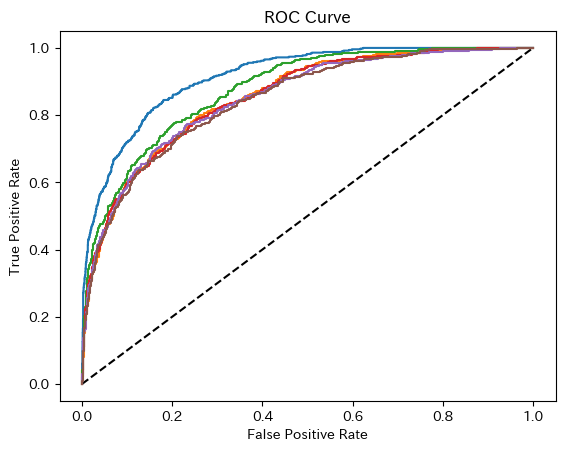

In [22]:
from sklearn.metrics import roc_curve
plt.plot([0, 1], [0, 1], 'k--')
for i in range(6):
    fpr, tpr, thresholds = roc_curve(y, Rc.oof_valid_df[i+1])
    plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [23]:
Rc.RESULT_CONFIG

,ID,model_name,layer1,layer2,feature_selection,under_sampling,PCA(d),columns,skf_num,skf_rand,score,date
0,1,LAMA,"[[lgb, lgb_tuned, linear_l2, cb, cb_tuned]]",[],True,False,False,"[car_count, marriage_var, MonthlyIncomeGroup_r...",5,42,0.914950,0821
0,2,LAMA,"[[lgb, lgb_tuned, linear_l2, cb, cb_tuned]]",[],True,False,False,"[car_count, marriage_var, MonthlyIncomeGroup_r...",3,42,0.854170,0821
0,3,LAMA,"[lgb, lgb_tuned, linear_l2, cb, cb_tuned]","[linear_l2, rf]",True,False,False,"[car_count, marriage_var, Lvl_0_Pipe_1_Mod_2_C...",5,42,0.876647,0821
0,4,LAMA,"[lgb, lgb_tuned, linear_l2, cb, cb_tuned]","[linear_l2, rf]",True,False,False,"[car_count, marriage_var, Lvl_0_Pipe_1_Mod_2_C...",3,42,0.853502,0821
0,5,LAMA,"[[nn, mlp, dense, denselight, resnet, snn, nod...",[],True,False,False,"[car_count, marriage_var, MonthlyIncomeGroup_r...",5,42,0.850929,0821
0,6,LAMA,"[[nn, mlp, dense, denselight, resnet, snn, nod...",[],True,False,False,"[car_count, marriage_var, MonthlyIncomeGroup_r...",3,42,0.844871,0821
0,7,LAMA,"[[nn_tuned, mlp_tuned, dense_tuned, denselight...",[],True,False,False,"[car_count, marriage_var, MonthlyIncomeGroup_r...",5,42,0.858295,0821
0,8,LAMA,"[[nn_tuned, mlp_tuned, dense_tuned, denselight...",[],True,False,False,"[car_count, marriage_var, MonthlyIncomeGroup_r...",3,42,0.853287,0821
0,9,LAMA,"[nn, mlp, dense, denselight, resnet, snn, node...","[linear_l2, rf]",True,False,False,"[car_count, marriage_var, MonthlyIncomeGroup_r...",5,42,0.862542,0821
0,10,LAMA,"[lgb_tuned, cb_tuned, et_tuned, resnet_tuned, ...","[linear_l2, mlp]",True,False,False,"[car_count, marriage_var, MonthlyIncomeGroup_r...",5,42,0.857566,0821


In [24]:
Rc.oof_valid_df.mean(axis=1)

0       0.810959
1       0.202638
2       0.362799
3       0.128263
4       0.668284
          ...   
3484    0.406246
3485    0.169367
3486    0.047535
3487    0.355065
3488    0.101386
Length: 3489, dtype: float32

In [25]:
score = roc_auc_score(y, Rc.oof_valid_df.mean(axis=1).values)
print(score)

0.8695488438653312
